# Best Neighborhood in Pittsburgh to Raise a Child!

## Introduction

There are a lot of things to consider when asking the question, “what is the best neighborhood in Pittsburgh? “Best neighborhood” could be defined objectively as where there are the most amenities, least crime, least pollution, or any number of things. However, this doesn’t fully capture what makes a neighborhood “the best”. Community is a major aspect that is a bit more difficult to quantify. Regardless, it is important to try to look at both sides of this. That is what we tried to do by choosing “best place to raise a child”.

## Imports

In [1]:
## imports 
import pandas as pd
from collections import defaultdict
import geopandas
import matplotlib.pyplot as plt

## Firearm Seizure Preprocessing

In [2]:
# Firearm Seizures
df_fire = pd.read_csv('firearms.csv')
df_fire = df_fire.dropna()
num_seize = df_fire.groupby("neighborhood").sum()['total_count']
num_seize = num_seize.sort_values(ascending=False)
fire_scores = 10-(num_seize-3)/340*10
fire_scores = fire_scores.sort_values(ascending=False).rename("score")
num_seize = num_seize.sort_values(ascending=False).rename("score")
fire_scores = pd.DataFrame(fire_scores)
num_seize = pd.DataFrame(num_seize)
print(fire_scores.head())

FileNotFoundError: [Errno 2] No such file or directory: 'firearms.csv'

## Playground Preprocessing

In [2]:
# Playgrounds
playground_equipment = pd.read_csv("Playground Equipment.csv")
playground_equipment_counts = playground_equipment["neighborhood"].value_counts()
playground_equipment_counts.index.name = "neighborhood"
playground_equipment_counts = playground_equipment_counts.rename("score")
playground_equipment_scale = playground_equipment_counts / 3.2
playground_scores = pd.DataFrame(playground_equipment_scale)
playground_scores = playground_scores.dropna()
print(playground_scores.head())

                       score
neighborhood                
Squirrel Hill South  10.0000
East Liberty          8.1250
Beechview             6.5625
Allegheny Center      4.6875
South Side Slopes     4.3750


## Household Preprocessing

In [4]:
# Households
households = pd.read_csv('household-type.csv')
family_dict = {}
for index, row in households.iterrows():
    percent_family_households = round((float(row[4]) / float(row[2])), 4) * 100
    family_dict.update({row[0] : percent_family_households})
families_to_neighborhood = pd.DataFrame({'neighborhood' : family_dict.keys() , 'num_families' : family_dict.values() })
family_scores = families_to_neighborhood.sort_values(by=['num_families'], ascending=False)
scores = family_dict
for key, value in scores.items():
    scores[key] = value / 7.15
scores_df = pd.DataFrame({'neighborhood' : scores.keys() , 'score' : scores.values() })
house_scores = scores_df.sort_values(by=['score'], ascending=False)
house_scores = house_scores.dropna()
print(house_scores.head())

         neighborhood      score
55      New Homestead  10.000000
40     Homewood North   9.882517
58  Northview Heights   9.707692
11            Bon Air   9.662937
43          Knoxville   9.123077


## Graphing of Individual Metrics

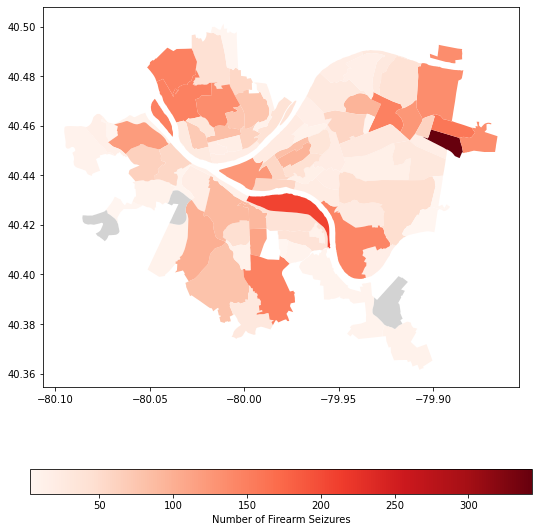

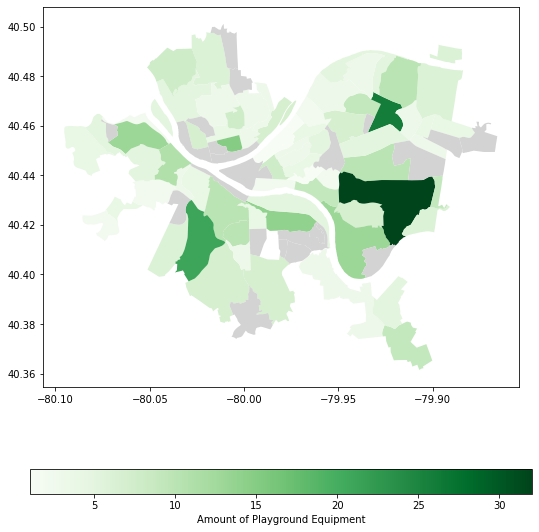

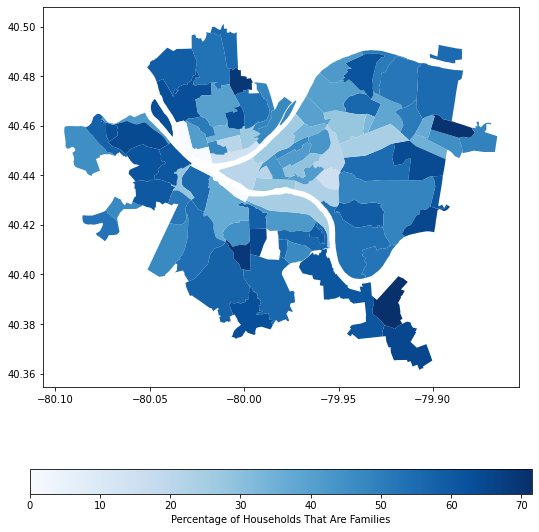

In [6]:
# Firearms

# plot map
neighborhoods = geopandas.read_file('Neighborhoods/Neighborhoods_.shp') # read in the shapefile

# do the merge
score_map = neighborhoods.merge(num_seize, how='left', left_on="hood", right_on='neighborhood')

# look at the head to confirm it merged correctly
score_map[['hood','score','geometry']].head()

score_map.plot(column='score', # set the data to be used for coloring
               cmap='Reds',              # choose a color palette
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Firearm Seizures", "orientation": "horizontal", "shrink": .6}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

# playground

# do the merge
play_map = neighborhoods.merge(playground_equipment_counts, how='left', left_on="hood", right_on='neighborhood')

# look at the head to confirm it merged correctly
play_map[['hood','score','geometry']].head()

play_map.plot(column='score', # set the data to be used for coloring
               cmap='Greens',              # choose a color palette
               legend=True,              # show the legend
               legend_kwds={'label': "Amount of Playground Equipment", "orientation": "horizontal", "shrink": .6}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )

# families

# do the merge
families_map = neighborhoods.merge(family_scores, how='left', left_on="hood", right_on='neighborhood')

# look at the head to confirm it merged correctly
play_map[['hood','score','geometry']].head()

families_map.plot(column='num_families', cmap='Blues', legend=True, legend_kwds={"label": "Percentage of Households That Are Families", "orientation": "horizontal", "shrink": .6}, figsize=(15,10))


## Merging Datasets and Score

In [16]:
# merge 
df_all = fire_scores.merge(playground_scores, how='inner', on='neighborhood').merge(house_scores,how='inner', on='neighborhood')

# calculating score
df_all['avg_scores'] = df_all[['score_x', 'score_y', 'score']].mean(axis=1)
df_all = df_all.sort_values(by=['avg_scores'], ascending=False)
df_all = df_all.rename(columns={'score_x': 'firearm_score', 'score_y': 'playground_score', 'score': 'family_score'})
print(df_all[["neighborhood", "avg_scores"]].head(10))

           neighborhood  avg_scores
36  Squirrel Hill South    8.489840
10        Lincoln Place    7.242299
1         Regent Square    7.120703
54            Beechview    7.081261
0        Swisshelm Park    6.996096
14  Squirrel Hill North    6.830793
12              Bon Air    6.778577
37              Elliott    6.777261
25           Greenfield    6.616977
55             Sheraden    6.530637


## Group Map and Plots

           neighborhood  avg_scores
36  Squirrel Hill South    8.489840
10        Lincoln Place    7.242299
1         Regent Square    7.120703
54            Beechview    7.081261
0        Swisshelm Park    6.996096
14  Squirrel Hill North    6.830793
12              Bon Air    6.778577
37              Elliott    6.777261
25           Greenfield    6.616977
55             Sheraden    6.530637


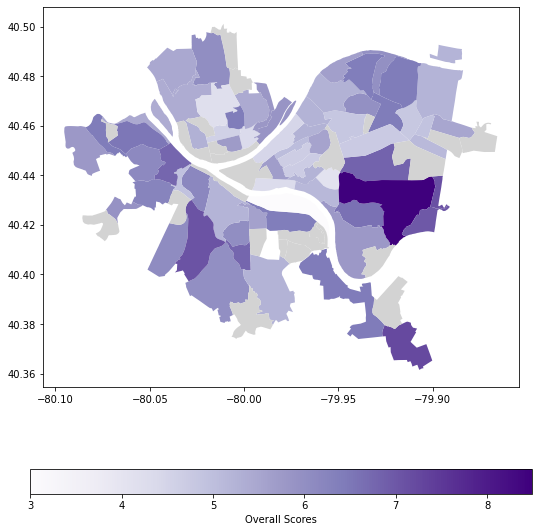

In [17]:
print(df_all[["neighborhood", "avg_scores"]].head(10))

# do the merge
all_map = neighborhoods.merge(df_all, how='left', left_on="hood", right_on='neighborhood')

# look at the head to confirm it merged correctly
all_map[['hood','avg_scores','geometry']].head()

all_map.plot(column='avg_scores', # set the data to be used for coloring
               cmap='Purples',              # choose a color palette
               legend=True,              # show the legend
               legend_kwds={'label': 'Overall Scores', 'orientation': 'horizontal', 'shrink': .6}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={'color': 'lightgrey'} # set disctricts with no data to gray
               )


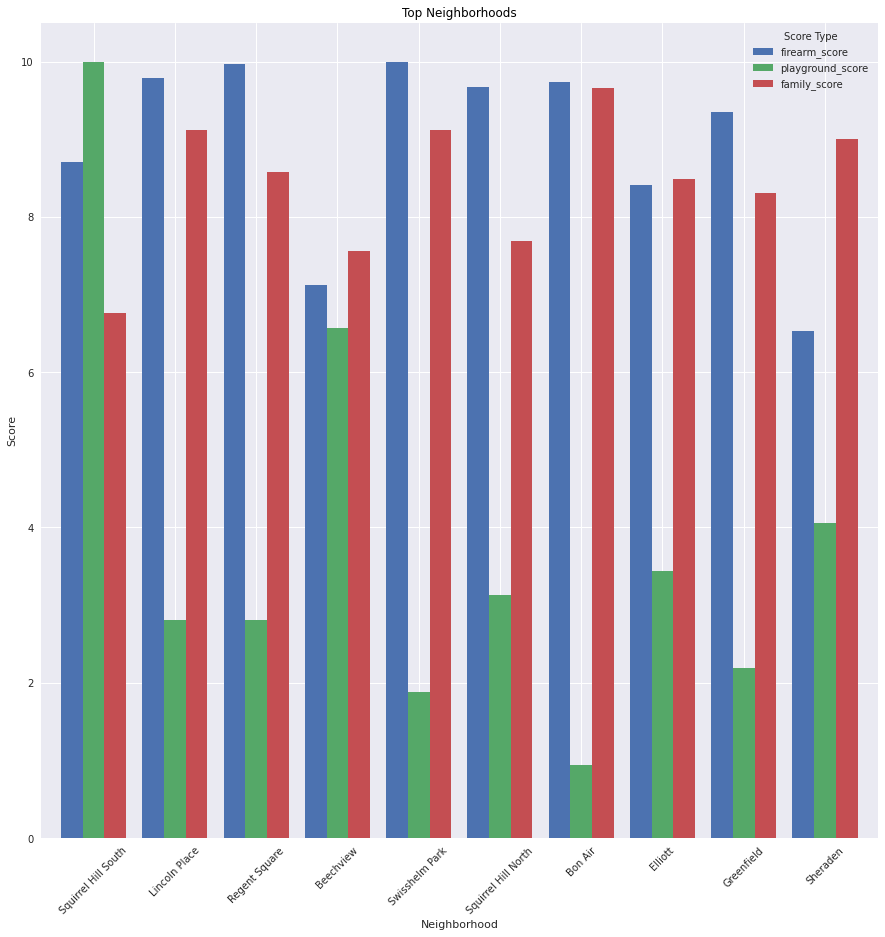

In [8]:
plot_data = df_all[["firearm_score", "playground_score", "family_score", "neighborhood"]].set_index("neighborhood")
plot_data = plot_data.head(10)
# Plot the data
plt.style.use("seaborn")
plot_data.plot(kind="bar", figsize=(15, 15), width = 0.8)
plt.title("Top Neighborhoods", color = "black")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Score Type")
plt.show()

In [2]:
avg_plot_data = df_all.set_index("neighborhood")
avg_plot_data = avg_plot_data.head(10)

plt.style.use("seaborn")
avg_plot_data.plot(kind="bar", y="avg_scores", figsize=(15, 15), width = 0.5, legend = False)
plt.title("Top Neighborhoods", color = "black")
plt.xlabel("Neighborhood")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()

NameError: name 'df_all' is not defined

## Conclusion

Aaron's Response: I was very excited to see that Squirrel Hill South was the best neighborhood to raise a child since it is my favorite neighborhood in Pittsburgh. I go to Murray Ave. in Squirrel Hill every weekend to go out to Thai restaurants, do grocery shopping at the Asian supermarket, and visit cool different shops. It’s important that I raise my child in a place that is both fun and safe at the same time knowing that I can take them most places without having to worry as much. One metric that set Squirrel Hill apart was its abundance of playgrounds compared to the other neighborhoods that came in top 5, which is amazing since outdoor time is crucial for a family’s health.

Mason's Response: Squirrel Hill being the best neighborhood to raise a child is certainly no surprise, given how wonderful of a place it is. However, it is critical to notice that Squirrel Hill was an outlier from my dataset, having a max score of 10, while the median score of my dataset was 1.5625. Nonetheless, since there was no preference on whether any of our datasets were more significant than others, there was no emphasis on weight to dampen the impact of my dataset towards the average score a neighborhood received. Still, Squirrel Hill having a higher score by 1 point than the other neighborhoods candidly proves that Squirrel Hill was still a relatively highly scored neighborhood for both the different datasets my partners analyzed.

Quinn's Response: I honestly don't think I've spent much, if any time in Squirrel Hill South, so its difficult for me to comment on how it compares to my favorite neighborhood, North Oakland. In order to do this, I looked around a bit on Google Maps' streetview, and I now fully understand how it ranked so high. To deal specifically with our metric, the inclusion of two very large parks within the neighborhood certainly helps a lot, leading to an excess of playground equipment and also families who want to take advantage of that. Generally, it has some similarities to North Oakland in the fact that it seems to be quite walkable with a good amount of amenities around, though it seems to have a slightly more quiet, small-town feel. I think I'm going to have to check out Squirrel Hill South in person sometime soon to get a better grasp.